# Part II: Convolutional Neural Networks

## Workshop em Deep Learning


```
	
	@author: Rafa Felix <rafael.felixalves@adelaide.edu.au>
	Australian Centre for Robotic Vision (ACRV)
	School of Computer Science
	The University of Adelaide
	
	References:
  [1]
	

```

---

### Instituto Federal de Minas Gerais


# Verificando versão do Python

In [1]:
import sys
sys.version

'3.6.3 (default, Oct  3 2017, 21:45:48) \n[GCC 7.2.0]'

In [2]:
# pip3: assistente de pacotes do python 3.
# pytorch: framework para desenvolvimento de algoritmos Deep Learning;

# instalação do pytorch
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

#torchvision: framework do pytorch com banco de dados e modelos de deep learning
#             que já são considerados estáveis pela comunidade científica.

# instalação do torchvision
!pip3 install torchvision


    95% |██████████████████████████████▋ | 565.8MB 52.4MB/s eta 0:00:01

    100% |████████████████████████████████| 592.3MB 48.6MB/s 
    100% |████████████████████████████████| 61kB 2.7MB/s 
    100% |████████████████████████████████| 2.0MB 7.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


# Importando e verificando Pytorch e TorchVision

In [0]:
import torch #importando torch
import torch.nn as nn # importando pacote de neural networks nn

# importando pacote de datasets, a este atribuimos o alias dsets
import torchvision.datasets as dsets 

# importando pacote de data augmentation
import torchvision.transforms as transforms 

# importando pacote de grafos e gradientes
from torch.autograd import Variable

In [0]:
# importando pacote time
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
input_size    = 784   # The image size = 28 x 28 = 784
num_classes   = 10    # The number of output classes. In this case, from 0 to 9
num_epochs    = 5     # The number of times entire dataset is trained
batch_size    = 100   # The size of input data took for one iteration
learning_rate = 1e-3  # The speed of convergence

# use_cuda é um parametro que utilizamos em nosso código para
# definir onde utilizaremos a GPU ou não. Como estamos utilizando o Google Colab
# podemos utilizar use_cuda como True. Caso você tente executar em uma outra
# plataforma que não possua GPU, utilize está flag como False.
use_cuda = True

# Dataset

In [6]:
# dsets é o alias que atribuimos ao pacote torchvision.datasets

# MNIST consiste em um dataset de caracteres.
# Normalmente o MNIST é o dataset mais utilizado educacionalmente
# em visão computacional;
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

Processing...
Done!


In [0]:

# Para treino, utilizamos a função shuffle = true
# Utilizamos a função shuffle para evitar overfitting
# e adicionar estocasticidade ao processo.

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

# Para test, utilizamos a função shuffle = false
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## Visualizando exemplares do MNIST



torch.Size([60000, 28, 28])
torch.Size([60000])


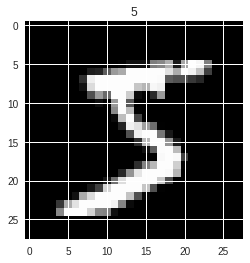

In [8]:
# Informacoes do dataset

# dimensoes
print(train_loader.dataset.train_data.size())                 # (60000, 28, 28)

# classes
print(train_loader.dataset.train_labels.size())               # (60000)

# plotting digito
plt.imshow(train_loader.dataset.train_data[0].numpy(),  # mudar o numero dentro para exibir outros exemplares
           cmap='gray')
plt.title('%i' % train_loader.dataset.train_labels[0])
plt.show()

#Implementacao

## Modelo

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x                    # return x for visualization

In [10]:
net = CNN()

print(net)

CNN(
  (conv1): Sequential(
    (0): Conv2d (1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d (16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (out): Linear(in_features=1568, out_features=10)
)


In [0]:
if use_cuda and torch.cuda.is_available():
    net.cuda()

## Optimizer e Funcao Objetivo

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Treinando a Rede

In [14]:
for epoch in range(num_epochs):
    start = time.time()

    for i, (images, labels) in enumerate(train_loader):   # Load a batch of images with its (index, data, class)
        
        #images = Variable(images.view(-1, 28*28))         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
        images = Variable(images)
        labels = Variable(labels)
        
        if use_cuda and torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = net(images) [0]                          # Forward pass: compute the output class given a image
        loss = criterion(outputs, labels)                 # Compute the loss: difference between the output class and the pre-given label
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()                                  # Optimizer: update the weights of hidden nodes
        
        if (i+1) % 100 == 0:                              # Logging
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    runtime = time.time() -  start
    print("Resumo da epoch [%d/%d] runtime: %.4f"%(epoch+1, num_epochs, runtime))
    print("-"*70)

Epoch [1/5], Step [100/600], Loss: 0.2889
Epoch [1/5], Step [200/600], Loss: 0.0968
Epoch [1/5], Step [300/600], Loss: 0.1249
Epoch [1/5], Step [400/600], Loss: 0.1027
Epoch [1/5], Step [500/600], Loss: 0.0674
Epoch [1/5], Step [600/600], Loss: 0.1202
Resumo da epoch [1/5] runtime: 10.6538
----------------------------------------------------------------------
Epoch [2/5], Step [100/600], Loss: 0.0344
Epoch [2/5], Step [200/600], Loss: 0.0534
Epoch [2/5], Step [300/600], Loss: 0.0204
Epoch [2/5], Step [400/600], Loss: 0.1273
Epoch [2/5], Step [500/600], Loss: 0.1240
Epoch [2/5], Step [600/600], Loss: 0.0660
Resumo da epoch [2/5] runtime: 8.2841
----------------------------------------------------------------------
Epoch [3/5], Step [100/600], Loss: 0.0499
Epoch [3/5], Step [200/600], Loss: 0.0110
Epoch [3/5], Step [300/600], Loss: 0.0301
Epoch [3/5], Step [400/600], Loss: 0.0756
Epoch [3/5], Step [500/600], Loss: 0.0421
Epoch [3/5], Step [600/600], Loss: 0.0561
Resumo da epoch [3/5] run

## Testando a Neural Network


In [17]:
correct = 0
total = 0
for images, labels in test_loader:
    #images = Variable(images.view(-1, 28*28))
    images = Variable(images)
    
    if use_cuda and torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    
    
    outputs = net(images)[0]
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    correct += (predicted == labels).sum()     # Increment the correct count
    
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10K test images: 98 %
